In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[1.2567e-10, 7.4408e-07, 8.4712e-01, 1.6031e-05, 1.3276e-01, 1.2318e-02,
          3.5105e-06, 3.5775e-03, 4.2043e-03, 5.8204e-07]]),
 tensor([[0.0035, 0.0197, 0.3196, 0.0363, 0.2206, 0.1371, 0.0268, 0.1071, 0.1106,
          0.0187]]),
 tensor([[0.0213, 0.0509, 0.2052, 0.0692, 0.1705, 0.1344, 0.0594, 0.1188, 0.1207,
          0.0496]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

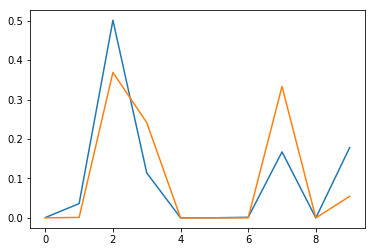

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

## Minimise width

with torch.no_grad():
    u,d = [],[]
    b = x[m]
    b[:,0] += 0.2
    u.append(to_shape(net(b)))
    b[:,0] -= 0.2
    b[:,2] *= 3.5/3
    u.append(to_shape(net(b)))
    b[:,2] /= 3.5/3
    b[:,0] -= 0.2
    d.append(to_shape(net(b)))
    b[:,0] += 0.2
    b[:,2] *= 2.5/3
    d.append(to_shape(net(b)))
    b[:,2] /= 2.5/3
    b_up,b_dw = torch.stack(u),torch.stack(d)

nll,alpha = calc_profile(f_s=f_s, f_b_nom=f_b, f_b_up=b_up, f_b_dw=b_dw, verbose=False, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

nll

plot_likelihood(to_np(nll-nll[nll==nll].min()))

nll = nll-nll[nll==nll].min()-0.5

nll

plot_likelihood(to_np(nll))

nll.max()-nll.min()

def get_diff_width(nll:Tensor, mu_scan:np.ndarray) -> Tensor:
    def lin_root(nll0,nll1,mu0,mu1):
        a = (nll1-nll0)/(mu1-mu0)
        b = nll1-(a*mu1)
        return -b/a
    
    u,r,last_mu,last_nll = True,torch.zeros((2)),mu_scan[0],nll[0]

    for mu,l in zip(mu_scan[1:],nll[1:]):
        if u and l < 0:
            r[0] = lin_root(last_nll,l,last_mu,mu)
            u = False
        elif not u and l > 0:
            r[1] = lin_root(last_nll,l,last_mu,mu)
            break
        if l == l: last_mu,last_nll = mu,l
    return r[1]-r[0]

w = get_diff_width(nll, mu_scan=np.linspace(20,80,61)); w

class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:int, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        r'''
        Fake loss function, callback computes loss in `on_forwards_end`
        '''
        self.wrapper.loss_func = lambda x,y: None
        self.profiler = partialler(calc_profile, n=self.n, mu_scan=to_device(self.mu_scan, self.wrapper.device), true_mu=self.true_mu,
                                   n_steps=self.n_steps, lr=self.lr, verbose=False)
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)
        f = f + 1e-7
        f = f/f.sum()
        return f
    
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
        
    def _get_diff_width(self, nll:Tensor) -> Tensor:
        def lin_root(nll0,nll1,mu0,mu1):
            a = (nll1-nll0)/(mu1-mu0)
            b = nll1-(a*mu1)
            return -b/a

        u,r,last_mu,last_nll = True,torch.zeros((2)),self.mu_scan[0],nll[0]
        for mu,l in zip(self.mu_scan[1:],nll[1:]):
            if u and l < 0:
                r[0] = lin_root(last_nll,l,last_mu,mu)
                u = False
            elif not u and l > 0:
                r[1] = lin_root(last_nll,l,last_mu,mu)
                break
            if l == l: last_mu,last_nll = mu,l
        return r[1]-r[0]
        
    def on_forwards_end(self) -> None:
        # Get sig. & bkg. shapes
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        
        # Compute nll
        nll,_ = self.profiler(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)
        try: nll = nll-nll[nll==nll].min()-0.5
        except RuntimeError: print(nll, self.wrapper.y_pred)
        w = self._get_diff_width(nll)
        print(w)
        print(self.wrapper.model[4].weight)
        self.wrapper.loss_val = torch.clamp_min(w, 0)

class PaperInferno(AbsInferno):
    def __init__(self, n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, n_steps:int=100, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, n_steps=n_steps, lr=lr)
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        with torch.no_grad():
            u,d = [],[]
            x[:,0] += 0.2
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] -= 0.2
            x[:,2] *= 3.5/3
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 3.5/3
            x[:,0] -= 0.2
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] += 0.2
            x[:,2] *= 2.5/3
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 2.5/3
            return torch.stack(u),torch.stack(d)

net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=nn.BCELoss(),
          cbs=[PaperInferno(),LossTracker(),EarlyStopping(5),GradClip(1e-5)])

model.save('weights/Inferno_Test.h5')

In [14]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:float, aug_alpha:bool=False, n_alphas:int=0, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
    
    @staticmethod
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
        
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
    
    def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:       
        if self.aug_alpha: alpha = torch.randn((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        else:              alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad():
            alpha /= 10
            alpha[0] += self.true_mu
        get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.n-self.true_mu,
                             f_s=f_s, f_b_nom=f_b_nom[None,:], f_b_up=f_b_up, f_b_dw=f_b_dw)
        if self.aug_alpha:  # Alphas carry noise, optimise via Newton
            for i in range(self.n_steps):  # Newton optimise nuisances & mu
                nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
                g,h = calc_grad_hesse(nll, alpha)
                s = torch.clamp(self.lr*g.detach()@torch.inverse(h), -100, 100)
                alpha = alpha-s
        nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
        return ikk
        
    def on_forwards_end(self) -> None:
        
    
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        self.wrapper.loss_val = self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [15]:
class PaperInferno(AbsInferno):
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, aug_alpha:bool=False, n_steps:int=10, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, aug_alpha=aug_alpha, n_alphas=(r_mods is not None)+(l_mods is not None), n_steps=n_steps, lr=lr)
        self.r_mods,self.l_mods,self.l_init = r_mods,l_mods,l_init
        
    def on_train_begin(self) -> None:
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        if self.r_mods is None and self.l_mods is None: return None,None
        u,d = [],[]
        if self.r_mods is not None:
            x = x+self.r_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x-self.r_mod_t[1]
        if self.l_mods is not None:
            x = x*self.l_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x/self.l_mod_t[1]
        return torch.stack(u),torch.stack(d)

In [16]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(aug_alpha=True, n_steps=10, r_mods=None),LossTracker(),SaveBest('weights/best_ii1la.h5'),EarlyStopping(10)])

1: Train=577.6956829833985 Valid=508.75406982421873
2: Train=469.0628930664063 Valid=444.7562872314453
3: Train=419.7155258178711 Valid=416.82049682617185
4: Train=397.11488250732424 Valid=395.9557244873047
5: Train=381.7602557373047 Valid=381.87693115234373
6: Train=370.13663970947266 Valid=369.67205078125
7: Train=360.26046524047854 Valid=360.29602478027346
8: Train=351.4331491088867 Valid=352.12437622070314
9: Train=344.4430911254883 Valid=345.3548681640625
10: Train=338.7327713012695 Valid=339.68341796875
11: Train=333.69353088378904 Valid=334.2880145263672
12: Train=328.97888610839846 Valid=330.80277465820313
13: Train=324.9096974182129 Valid=326.4488049316406
14: Train=322.1163803100586 Valid=322.5622119140625
15: Train=318.13200714111326 Valid=319.4869494628906
16: Train=315.64909301757814 Valid=317.37290161132813
17: Train=313.0786123657227 Valid=314.3113171386719
18: Train=310.5187300109863 Valid=311.7255224609375
19: Train=308.4386563110352 Valid=309.010908203125
20: Train=30

156: Train=261.2233659362793 Valid=261.1692529296875
157: Train=260.84811828613283 Valid=261.27866455078123
158: Train=260.95607421875 Valid=261.2609289550781
159: Train=261.0535963439941 Valid=260.99485778808594
160: Train=260.8822052001953 Valid=261.03621063232424
161: Train=260.77757278442385 Valid=260.7522073364258
162: Train=260.6244253540039 Valid=260.99458953857425
163: Train=260.55406188964844 Valid=260.7422720336914
164: Train=260.49525009155275 Valid=260.634934387207
165: Train=260.29437118530274 Valid=260.53349822998047
166: Train=260.3504841613769 Valid=260.4192269897461
167: Train=260.7087605285644 Valid=260.22859344482424
168: Train=260.29086563110354 Valid=260.3422009277344
169: Train=260.24742752075196 Valid=260.17831329345705
170: Train=260.22387771606446 Valid=260.37141845703127
171: Train=260.31324447631835 Valid=260.19830444335935
172: Train=259.8343655395508 Valid=259.8239645385742
173: Train=260.12459259033204 Valid=259.99717803955076
174: Train=259.8138973999023 

In [17]:
model.save('weights/Inferno_Test_interp_bm1la.h5')

model.load('weights/Inferno_Test_interp_bm1.h5')

# Results

In [18]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [19]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [20]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,2,1.0
1,2,1.0
2,5,1.0
3,5,1.0
4,9,1.0


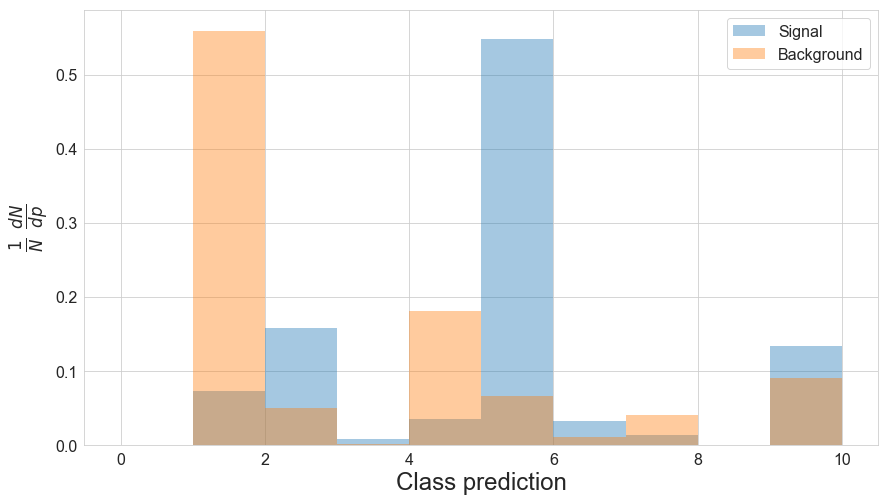

In [21]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [22]:
bin_preds(df)

In [23]:
df.head()

,pred,gen_target,pred_bin
0,2,1.0,2
1,2,1.0,2
2,5,1.0,5
3,5,1.0,5
4,9,1.0,9


In [24]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [25]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.0000))

In [26]:
f_s, f_b

(tensor([7.2670e-02, 1.5774e-01, 7.7480e-03, 3.4232e-02, 5.4807e-01, 3.2778e-02,
         1.2818e-02, 2.0000e-13, 1.3395e-01, 2.0000e-13]),
 tensor([5.5931e-01, 4.9710e-02, 1.1140e-03, 1.8121e-01, 6.6268e-02, 1.0956e-02,
         4.0728e-02, 2.0000e-13, 9.0704e-02, 2.0000e-13]))

In [27]:
asimov = (50*f_s)+(1000*f_b)

In [28]:
asimov, asimov.sum()

(tensor([5.6295e+02, 5.7597e+01, 1.5014e+00, 1.8292e+02, 9.3671e+01, 1.2595e+01,
         4.1369e+01, 2.1000e-10, 9.7401e+01, 2.1000e-10]), tensor(1050.0001))

In [29]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([25.10519981, 24.96695328, 24.83364487, 24.70619583, 24.58390427,
       24.46737671, 24.35553551, 24.24939156, 24.14790916, 24.05198288,
       23.96076393, 23.87447739, 23.79340744, 23.71686935, 23.64512634,
       23.57832527, 23.51597404, 23.45824432, 23.40521812, 23.35681152,
       23.31260109, 23.27294922, 23.23757935, 23.2066021 , 23.18008995,
       23.15753555, 23.13914108, 23.12491798, 23.1146698 , 23.10900116,
       23.10689545, 23.10861969, 23.11460495, 23.12487221, 23.13844299,
       23.15585899, 23.17708969, 23.2020092 , 23.23054504, 23.2629261 ,
       23.29844475, 23.338274  , 23.38139153, 23.42793846, 23.4780159 ,
       23.53179932, 23.5884819 , 23.6489563 , 23.7127018 , 23.77950478,
       23.84966469, 23.92348289, 24.00032997, 24.08035851, 24.16323662,
       24.24966049, 24.33904457, 24.43135452, 24.52695465, 24.62609482,
       24.72727966])

In [30]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [31]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

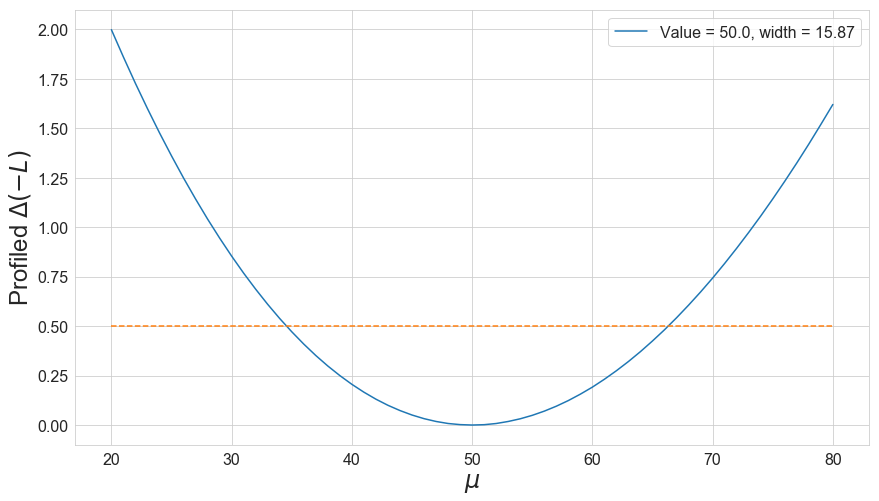

In [32]:
plot_likelihood(y-y.min())

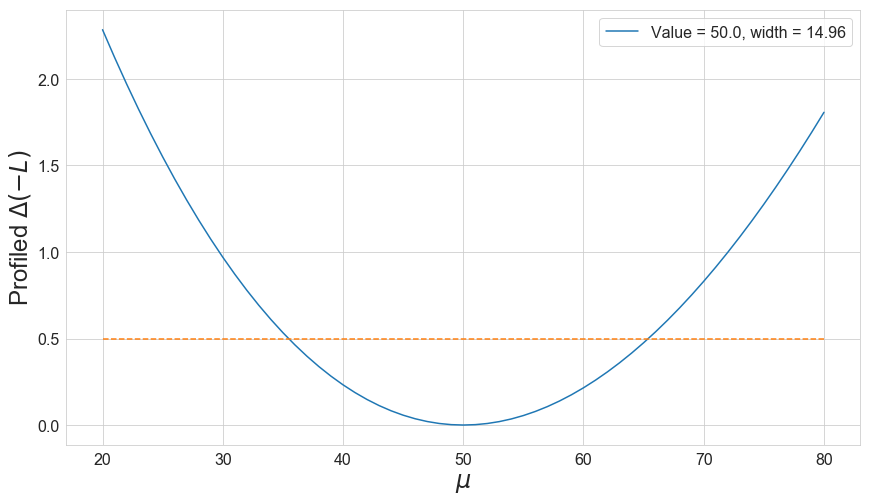

In [33]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [34]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [35]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [36]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,2,1.0,2,2,2,2,2,2,2,2,2,2,2
1,2,1.0,2,2,2,2,2,2,2,2,2,2,2
2,5,1.0,5,5,5,5,5,5,5,5,5,5,5
3,5,1.0,5,5,5,5,5,5,5,5,5,5,5
4,9,1.0,9,9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,0.0,1,1,1,1,1,1,1,1,1,1,1
999996,9,0.0,9,9,9,9,9,9,9,9,9,9,9
999997,4,0.0,4,4,4,4,4,4,4,4,4,4,4
999998,1,0.0,1,1,1,1,1,1,1,1,1,1,1


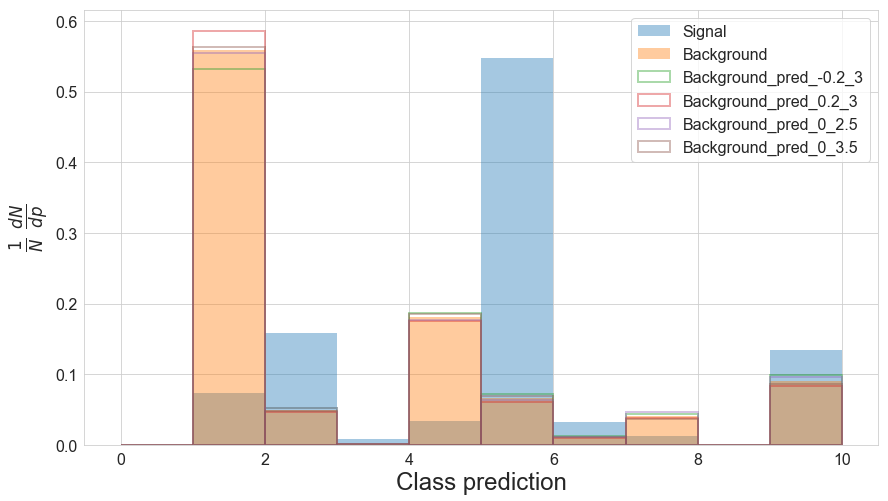

In [37]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([5.2724e-01, 5.5242e-02, 8.8600e-04, 1.8160e-01, 6.8924e-02, 1.1658e-02,
        4.9258e-02, 2.0000e-13, 1.0519e-01, 2.0000e-13])
tensor([5.3212e-01, 5.2570e-02, 1.2700e-03, 1.8663e-01, 7.2406e-02, 1.1754e-02,
        4.3948e-02, 2.0000e-13, 9.9306e-02, 2.0000e-13])
tensor([5.3562e-01, 5.0128e-02, 1.7940e-03, 1.9085e-01, 7.5766e-02, 1.1650e-02,
        3.9708e-02, 2.0000e-13, 9.4482e-02, 2.0000e-13])
tensor([5.5443e-01, 5.2382e-02, 7.3000e-04, 1.7618e-01, 6.2786e-02, 1.0860e-02,
        4.6038e-02, 2.0000e-13, 9.6592e-02, 2.0000e-13])
tensor([5.5931e-01, 4.9710e-02, 1.1140e-03, 1.8121e-01, 6.6268e-02, 1.0956e-02,
        4.0728e-02, 2.0000e-13, 9.0704e-02, 2.0000e-13])
tensor([5.6281e-01, 4.7268e-02, 1.6380e-03, 1.8544e-01, 6.9628e-02, 1.0852e-02,
        3.6488e-02, 2.0000e-13, 8.5880e-02, 2.0000e-13])
tensor([5.8155e-01, 4.9420e-02, 6.3400e-04, 1.7038e-01, 5.6544e-02, 1.0060e-02,
        4.2822e-02, 2.0000e-13, 8.8588e-02, 2.0000e-13])
tensor([5.8643e-01, 4.6748e-02, 1.0180e-0

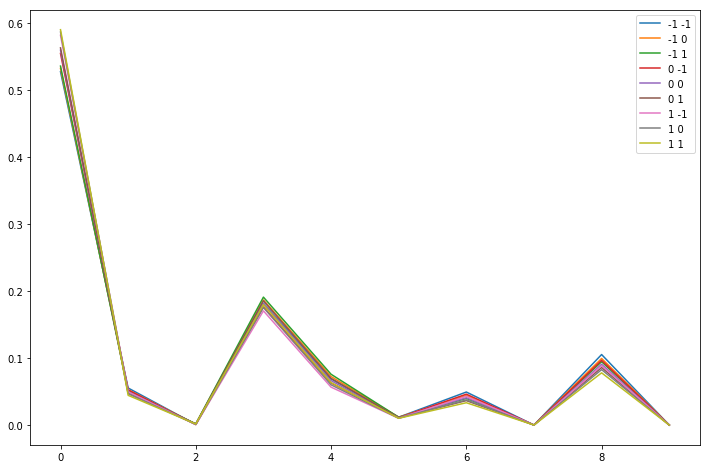

In [38]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [39]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [40]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [41]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [42]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [43]:
nll = to_np(nll)

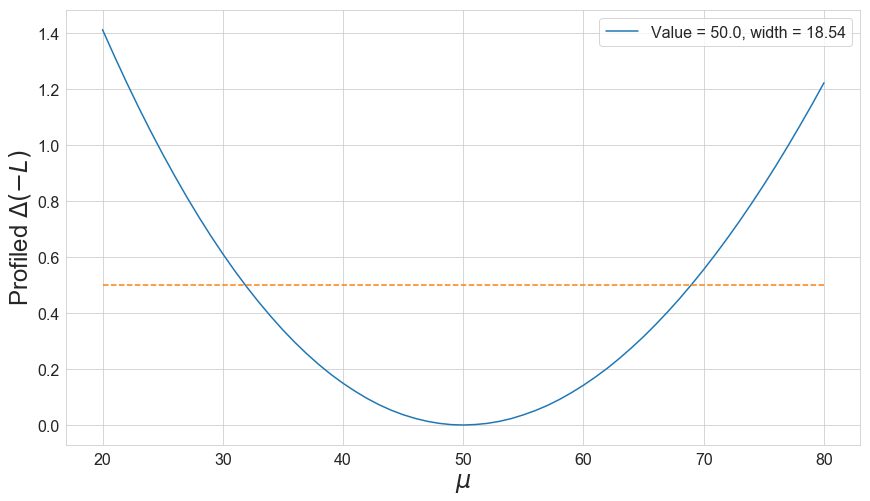

In [44]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [45]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [46]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [47]:
nll = to_np(nll)

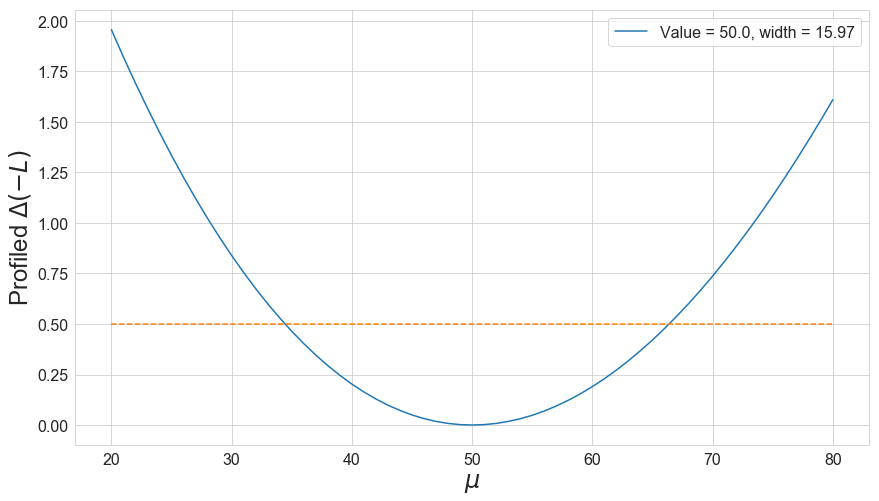

In [48]:
plot_likelihood(nll-nll.min())

## BM 2

In [49]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [50]:
nll = to_np(nll)

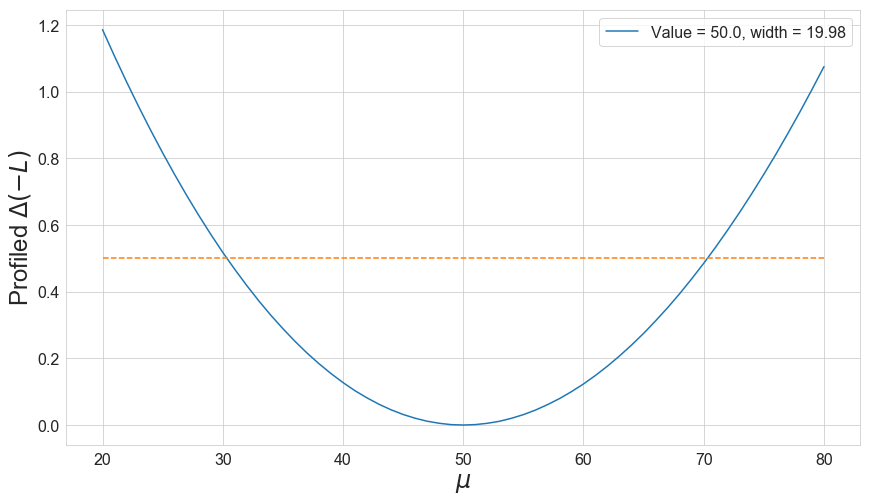

In [51]:
plot_likelihood(nll-nll.min())